In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2019-08-18 17:45:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   178MB/s    in 1.3s    

2019-08-18 17:45:02 (178 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
num_sentences = 0

embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []

In [0]:
with open("/tmp/training_cleaned.csv", "r") as csvfile:
  reader = csv.reader(csvfile, delimiter = ",")
  for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)

for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [7]:
corpus[5][0]


'In dire need of a cigarette. '

In [8]:
corpus[5][1]

0

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

In [0]:
sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences=sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [11]:
split = int(test_portion * training_size)

print(split)

16000


In [0]:
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]

test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [13]:
print(vocab_size)
print(word_index['i'])

138748
1


In [14]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2019-08-18 17:45:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   113MB/s    in 2.9s    

2019-08-18 17:45:20 (113 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
embeddings_index = {};

with open("/tmp/glove.6B.100d.txt" , "r") as f:
  for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

In [0]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [17]:
print(len(embeddings_matrix))

138749


In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv1D(64, 5, activation="relu"),
  tf.keras.layers.MaxPooling1D(pool_size=4),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13874900  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,940,053
Trainable params: 65,153
Non-trainable params: 13,874,900
_______________________________________

In [0]:
model.compile(loss='binary_crossentropy'
              ,optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [22]:
num_epochs = 10

history = model.fit(training_sequences, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(test_sequences, test_labels))

W0818 17:45:31.572047 140424469956480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 144000 samples, validate on 16000 samples
Epoch 1/10
144000/144000 [==============================] - 121s 843us/sample - loss: 0.6312 - accuracy: 0.6407 - val_loss: 0.5848 - val_accuracy: 0.6879
Epoch 2/10
144000/144000 [==============================] - 120s 833us/sample - loss: 0.5958 - accuracy: 0.6755 - val_loss: 0.5570 - val_accuracy: 0.7094
Epoch 3/10
144000/144000 [==============================] - 120s 836us/sample - loss: 0.5798 - accuracy: 0.6891 - val_loss: 0.5444 - val_accuracy: 0.7207
Epoch 4/10
144000/144000 [==============================] - 121s 842us/sample - loss: 0.5700 - accuracy: 0.6973 - val_loss: 0.5373 - val_accuracy: 0.7244
Epoch 5/10
144000/144000 [==============================] - 120s 835us/sample - loss: 0.5611 - accuracy: 0.7051 - val_loss: 0.5324 - val_accuracy: 0.7279
Epoch 6/10
144000/144000 [==============================] - 119s 829us/sample - loss: 0.5564 - accuracy: 0.7081 - val_loss: 0.5281 - val_accuracy: 0.7283
Epoch 7/10
144000/144000 

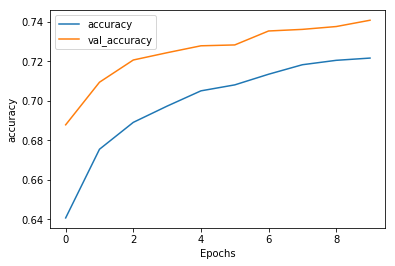

In [24]:
plot_graphs(history, 'accuracy')

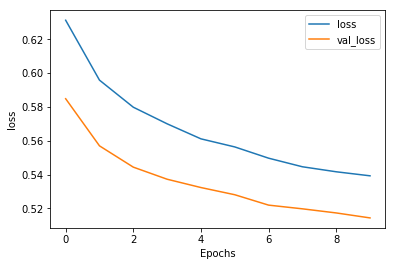

In [25]:
plot_graphs(history, 'loss')